In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.random as npr
import scipy.optimize as opt
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import sys
import glob

import scipy.stats as st
from scipy.special import logsumexp
import numpy.linalg as npl

import mope
import mope.likelihoods as lis
from mope import transition_data_mut

/home/peter/opt/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# for how many generations do heteroplasmies segregate?

The processes between germlines are

  - early oogenesis, pre-divergence
  - early oogenesis, post-divergence
  - late oogenesis

These are followed by somatic processes if you want to include those as well in the terminal generation. For now, just focus on the germlines, how many bottlenecks the frequencies will segregate through.

 - draw eoo_pre_l0, eoo_post_l0, loo_l0, and alphabeta from posterior sample. Assume average childbirth age (29.2).
 - get transition matrices (with mutation rate = 0), multiply to get beginning-to-end transition matrix
 - assess matrices for probability of lasting from each frequency some number of generations.
 - average these probabilities over P(f) (calculated using alphabeta).

In [2]:
trans = transition_data_mut.TransitionData('transitions/drift_transitions.h5', memory=True)

In [3]:
post_samples = pd.read_csv('results/downsampled_chains.txt.gz', sep='\t', compression='gzip')

In [4]:
def get_freq_distribution(log10ab, log10polyprob):
    return lis.get_stationary_distribution_double_beta(
        trans.get_bin_frequencies(),
        trans.get_breaks(),
        trans.get_N(),
        10**log10ab,
        10**log10polyprob)

In [5]:
def get_wright_fisher_transition_matrix(N, s, u, v):
    assert 3/2 == 1.5  # check for __future__ division
    P = np.matrix(np.zeros((N+1, N+1), dtype = np.float64))
    js = np.arange(0,N+1)
    for i in range(N+1):
        p = i/N
        pmut = (1-u)*p + v*(1-p) # first mutation, then selection
        pstar = pmut*(1+s) / (pmut*(1+s) + 1-pmut)
        P[i,:] = np.exp(st.binom.logpmf(js, N, pstar))
    return P

In [6]:
P_wf = get_wright_fisher_transition_matrix(2000, 0, 0, 0)

In [7]:
def get_wf_transition_matrix(total_drift):
    global P_wf
    num_generations = int(total_drift*1000+0.5)
    P = npl.matrix_power(P_wf, num_generations)
    return mope.make_transition_matrices.bin_matrix(P, trans.get_breaks())

In [8]:
identity_matrix = np.diag(np.ones_like(trans.get_bin_frequencies()))

def get_germline_transition_matrix(eoo_pre, eoo_post, loo):
    eoo_pre = eoo_pre
    eoo_post = eoo_post
    loo = loo * 29.2
    
    if eoo_pre == 0.0:
        eoo_pre_P = identity_matrix
    else:
        eoo_pre_P = trans.get_transition_probabilities_time_mutation(eoo_pre, 1.1e-8)
    eoo_pre_P[0,:] = 0.0
    eoo_pre_P[0,0] = 1.0
    eoo_pre_P[-1,:] = 0.0
    eoo_pre_P[-1,-1] = 1.0
    
    if eoo_post == 0.0:
        eoo_post_P = identity_matrix
    else:
        eoo_post_P = trans.get_transition_probabilities_time_mutation(eoo_post, 1.1e-8)
    eoo_post_P[0,:] = 0.0
    eoo_post_P[0,0] = 1.0
    eoo_post_P[-1,:] = 0.0
    eoo_post_P[-1,-1] = 1.0
        
    if loo == 0.0:
        loo_P = identity_matrix
    else:
        loo_P = trans.get_transition_probabilities_time_mutation(loo, 1.1e-8)
    loo_P[0,:] = 0.0
    loo_P[0,0] = 1.0
    loo_P[-1,:] = 0.0
    loo_P[-1,-1] = 1.0
    
    return np.matmul(eoo_pre_P, np.matmul(eoo_post_P, loo_P))

In [9]:
n_samples = 500
pnotfixeds = []
pnotfixeds_freqavg = []
freq_distns = []
for j, (_, sample) in enumerate(
    post_samples[['eoo_pre_l', 'eoo_post_l', 'loo_l', 'log10ab', 'log10polyprob']].sample(n_samples).iterrows()):
    sample_not_fixeds = []
    sample_pnot_freqavg = []
    P = get_germline_transition_matrix(*sample[:3])
    freq_distn = get_freq_distribution(*sample[-2:])
    freq_distn_1pct = freq_distn.copy()
    freq_distn_1pct 
    freq_distn[0] = 0
    freq_distn[-1] = 0
    freq_distn /= freq_distn.sum()
    freq_distns.append(freq_distn)
    for i in range(1, 101):
        Pp = npl.matrix_power(P, i)
        pnotfixed = 1.0 - Pp[:,0] - Pp[:,-1]
        sample_not_fixeds.append(pnotfixed)
        sample_pnot_freqavg.append(np.dot(pnotfixed, freq_distn))
    pnotfixeds.append(sample_not_fixeds)
    pnotfixeds_freqavg.append(sample_pnot_freqavg)
    print '\rsample {}'.format(j),
pnotfixeds = np.array(pnotfixeds)
pnotfixeds_freqavg = np.array(pnotfixeds_freqavg)

sample 499


In [10]:
# The probabilities of surviving X generations are
# estimated by marginalizing across the posterior samples.
pnotfixeds_avg = pnotfixeds.mean(0)
survive_lineage = pnotfixeds_avg

In [11]:
freqs = trans.get_bin_frequencies()  # the discretized frequencies

In [13]:
nfdat = pd.DataFrame.from_dict({'gens':np.arange(1,101),
                        'nf50':pnotfixeds_avg[:,idx50],
                        'nf15':pnotfixeds_avg[:,idx15],
                        'nf2':pnotfixeds_avg[:,idx2],
                        })
nfdat.set_index('gens', inplace=True)
print 'fraction of 2% heteroplasmies not surviving more than two generations:', 1.0-nfdat['nf2'][3]
print 'number of generations before survival probability dips below 10% for 15% initial freq:', nfdat.index[nfdat['nf15'] > 0.1][-1]
print 'number of generations before survival probability dips below 10% for 50% initial freq:', nfdat.index[nfdat['nf50'] > 0.1][-1]
print 'number of generations before survival probability dips below 1% for 50% initial freq:', nfdat.index[nfdat['nf50'] > 0.01][-1]

fraction of 2% heteroplasmies not surviving more than two generations: 0.9220857591796765
number of generations before survival probability dips below 10% for 15% initial freq: 11
number of generations before survival probability dips below 10% for 50% initial freq: 15
number of generations before survival probability dips below 1% for 50% initial freq: 28


Get distributions of the number of generations until fixation, X.

$$
P(X = g \mid x_0 = f) = \sum_{i \notin \{0,1\}} P(x_g = i \mid x_0 = f) - \sum_{j \notin \{0,1\}} P(x_{g+1} = j \mid x_0 = f)
$$

Since the number of generations before fixation occurs is a non-negative random variable, the mean is equal to $\sum_{i=0}^\infty P(X>i)$. (See [here](https://math.stackexchange.com/questions/64186/intuition-behind-using-complementary-cdf-to-compute-expectation-for-nonnegative), e.g.)

In [14]:
avg_num_gens = pnotfixeds_avg.sum(0)
survive = pnotfixeds_avg

# persistence calculations in a Birth-death process with Poisson(1) offspring counts.

### simulating persistence given Poisson offspring distributions

In [15]:
trans = transition_data_mut.TransitionData('transitions/drift_transitions.h5', memory=True)
freqs = trans.get_bin_frequencies()

In [16]:
identity_matrix = np.diag(np.ones_like(trans.get_bin_frequencies()))

def get_germline_transition_matrix(eoo_pre, eoo_post, loo):
    eoo_pre = eoo_pre
    eoo_post = eoo_post
    loo = loo * 29.2
    
    if eoo_pre == 0.0:
        eoo_pre_P = identity_matrix
    else:
        eoo_pre_P = trans.get_transition_probabilities_time_mutation(eoo_pre, 1.1e-8)
    eoo_pre_P[0,:] = 0.0
    eoo_pre_P[0,0] = 1.0
    eoo_pre_P[-1,:] = 0.0
    eoo_pre_P[-1,-1] = 1.0
    
    if eoo_post == 0.0:
        eoo_post_P = identity_matrix
    else:
        eoo_post_P = trans.get_transition_probabilities_time_mutation(eoo_post, 1.1e-8)
    eoo_post_P[0,:] = 0.0
    eoo_post_P[0,0] = 1.0
    eoo_post_P[-1,:] = 0.0
    eoo_post_P[-1,-1] = 1.0
        
    if loo == 0.0:
        loo_P = identity_matrix
    else:
        loo_P = trans.get_transition_probabilities_time_mutation(loo, 1.1e-8)
    loo_P[0,:] = 0.0
    loo_P[0,0] = 1.0
    loo_P[-1,:] = 0.0
    loo_P[-1,-1] = 1.0
    
    return np.matmul(eoo_pre_P, np.matmul(eoo_post_P, loo_P))

In [17]:
post_samples = pd.read_csv('results/downsampled_chains.txt.gz', sep='\t', compression='gzip')

In [18]:
Ps = []
freq_distns = []
n_samples = 10000
for j, (_, sample) in enumerate(
    post_samples[['eoo_pre_l', 'eoo_post_l', 'loo_l']].sample(n_samples).iterrows()):
    P = get_germline_transition_matrix(*sample)
    Ps.append(P)
    print '\r sample {}'.format(j),
Ps = np.array(Ps)
mean_P = Ps.mean(axis=0)

 sample 9999


In [19]:
# gen_means[i,j,k] gives the (Poisson) mean number of offspring
# in frequency category k given that you started with one
# member of frequency category j, i generations ago.
freq_means = np.identity(mean_P.shape[0])
gen_means = [freq_means]
for i in range(100):
    freq_means = np.dot(freq_means, mean_P)
    gen_means.append(freq_means)
gen_means = np.array(gen_means)
gen_means.shape

(101, 121, 121)

In this model, the probability of survival after $i$ generations given that you started in frequency category $j$ is

$$1 - \exp\left[\sum_{k \in F} \lambda(i,j,k)\right]$$,

where $\lambda(i,j,k) = \textrm{gen_means[i,j,k]}$.

In [20]:
freq_filt = (freqs > 0.01)&(freqs < 0.99)
survive_pois = 1.0-np.exp((-gen_means[:,:,freq_filt]).sum(-1))
survive_pois[0,1:] = 1.0  # there is gauranteed survival in the first generation

In [21]:
# (from the above calculations, for a single unbroken maternal lineage)
survive = gen_means[:,:,freq_filt].sum(-1)

In [22]:
# survive_pois[i, j] gives the probability of seeing a heteroplasmy at MAF >= 1% after i generations
# given that you start at frequency indexed j.

# same for survive

In [23]:
avg_num_gens_pois = survive_pois[1:,:].sum(0)

### comparing stochastic reproduction to survival in single unbroken lineage.

In [24]:
# Get the discrete-frequency indices closest to our frequencies of interest
closest_to_freq = lambda x: np.argmin(np.abs(freqs-x))
desired_freqs = [0.01, 0.1, 0.25, 0.5]
idxs = {df: closest_to_freq(df) for df in desired_freqs}
idxs

{0.01: 12, 0.1: 29, 0.25: 42, 0.5: 60}

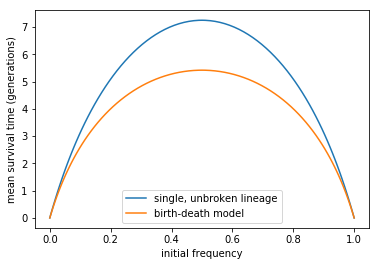

In [25]:
plt.plot(freqs, avg_num_gens, label='single, unbroken lineage')
ax = plt.gca()
ax.plot(freqs, avg_num_gens_pois, label='birth-death model')
ax.set_xlabel('initial frequency')
ax.set_ylabel('mean survival time (generations)')
ax.legend()

In [26]:
closest_to_freq = lambda x: np.argmin(np.abs(freqs-x))
desired_freqs = [0.01, 0.1, 0.25, 0.5]
idxs = {df: closest_to_freq(df) for df in desired_freqs}
idxs

{0.01: 12, 0.1: 29, 0.25: 42, 0.5: 60}

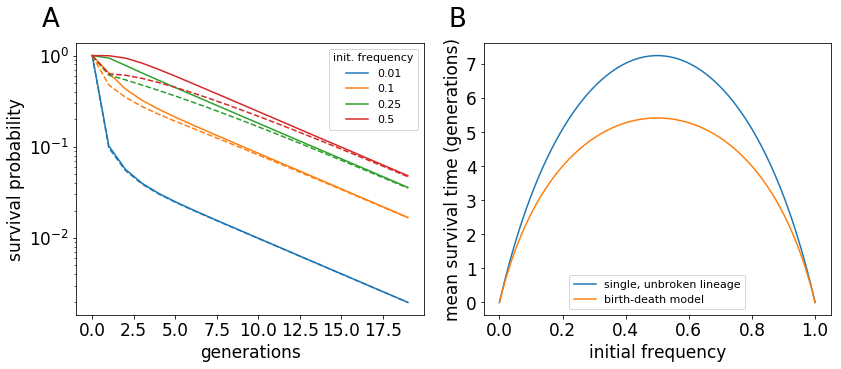

In [27]:
with mpl.rc_context({'font.size': 17}):
    f, axes = plt.subplots(1,2, figsize=(12,5))

    ax = axes[0]
    gens_to_plot = 20
    ci = 0
    for dfreq, idx in sorted(idxs.items()):
        color = 'C{}'.format(ci)
        ci += 1
        ax.plot(survive[:gens_to_plot, idx], color=color, label=dfreq)
        ax.plot(survive_pois[:gens_to_plot, idx], color=color, ls='--')
    ax.set_yscale('log')
    ax.set_xlabel('generations')
    ax.set_ylabel('survival probability')

    with mpl.rc_context({'font.size': 11}):
        ax.legend(title='init. frequency')

    ax = axes[1]
    ax.plot(freqs, avg_num_gens, label='single, unbroken lineage')
    ax = plt.gca()
    ax.plot(freqs, avg_num_gens_pois, label='birth-death model')
    ax.set_xlabel('initial frequency')
    ax.set_ylabel('mean survival time (generations)')
    with mpl.rc_context({'font.size': 11}):
        ax.legend()
    with mpl.rc_context({'font.size': 26}):
        axes[0].text(-0.1, 1.06, 'A', transform=axes[0].transAxes)
        axes[1].text(-0.1, 1.06, 'B', transform=axes[1].transAxes)
    f.tight_layout()


    #plt.savefig('reproductive_stochasticity_results.png', dpi=600, bbox_inches='tight')
    #plt.savefig('reproductive_stochasticity_results.pdf', dpi=600, bbox_inches='tight')

# conditional upon fixation.

Here we calculate the number of generations it takes for an allele to reach fixation, conditional on it eventually reaching fixation.

See [here](https://math.dartmouth.edu/archive/m20x06/public_html/Lecture14.pdf) for an example of the terminology of the different matrices, which is fairly standard for analyzing Markov chains.

In [28]:
# Fundamental matrix calculations. The first and last indices in the matrix correspond to the
# two absorbing states at 0 and 1.
import scipy.linalg as scl

Q = mean_P[1:-1,1:-1]
I = np.identity(Q.shape[0])
N = scl.inv(I-Q)
R = mean_P[1:-1,[0,-1]]

In [29]:
p_fix = np.dot(N,R)[:,1]
p_fix_all = np.concatenate(([0], p_fix, [1]))

In [30]:
# Multiply each entry p_ij of mean_P by p_fix[j]/p_fix[i]
with np.errstate(all='ignore'):
    conditional_factors = p_fix_all[np.newaxis,:]/p_fix_all[:,np.newaxis]

In [31]:
conditional_factors[:,0] = 0
conditional_factors[0,:] = 0

In [32]:
conditional_factors.shape

(121, 121)

In [33]:
with np.errstate(divide='ignore'):
    P_cond = np.exp(np.log(P)+np.log(conditional_factors))
    P_cond[0,0] = 1.0
    P_cond /= P_cond.sum(1)[np.newaxis,:]

In [34]:
P_cond_ns = np.array([npl.matrix_power(P_cond, i) for i in range(0,101)])

In [35]:
Q_cond = P_cond[1:-1, 1:-1]
I_cond = np.identity(Q_cond.shape[0])
N_cond = scl.inv(I_cond-Q_cond)

In [36]:
# These are the expected times until fixation conditional on eventual fixation,
# for each starting frequency
fixdat = pd.Series(N_cond.sum(1), index=freqs[1:-1], name='gens')
fixdat

0.00050    11.067140
0.00100    11.076373
0.00150    11.083640
0.00200    11.087505
0.00250    11.088610
0.00300    11.087914
0.00375    11.084688
0.00475    11.078667
0.00575    11.071829
0.00700    11.063062
0.00850    11.052190
0.01025    11.039591
0.01225    11.026219
0.01450    11.013318
0.01700    11.000964
0.01975    10.987624
0.02300    10.969903
0.02675    10.946333
0.03100    10.919440
0.03550    10.894051
0.04025    10.869359
0.04550    10.841428
0.05125    10.809548
0.05750    10.774558
0.06425    10.736764
0.07150    10.696159
0.07925    10.652643
0.08750    10.606161
0.09625    10.556635
0.10550    10.504022
             ...    
0.89450     3.295888
0.90375     3.129405
0.91250     2.966959
0.92075     2.809101
0.92850     2.656441
0.93575     2.509578
0.94250     2.369160
0.94875     2.235803
0.95450     2.110113
0.95975     1.992633
0.96450     1.884110
0.96900     1.779559
0.97325     1.679216
0.97700     1.589043
0.98025     1.509456
0.98300     1.441127
0.98550     1